In [173]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [174]:
import os
Path=os.getenv('HOME')+'/aiffel/kaggle/PetImages'
os.listdir(Path)

['Dog', 'Cat']

In [175]:
BATCH_SIZE=32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(Path,
                                                              validation_split=0.1,
                                                              subset="training",
                                                              batch_size=BATCH_SIZE,
                                                              image_size=(224, 224),
                                                              shuffle=True,
                                                              seed=23)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(Path,
                                                              validation_split=0.1,
                                                              subset="validation",
                                                              batch_size=BATCH_SIZE,
                                                              image_size=(224, 224),
                                                              shuffle=True,
                                                              seed=23)

Found 25000 files belonging to 2 classes.
Using 22500 files for training.
Found 25000 files belonging to 2 classes.
Using 2500 files for validation.


In [147]:
#train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
#valid_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

(32,)


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


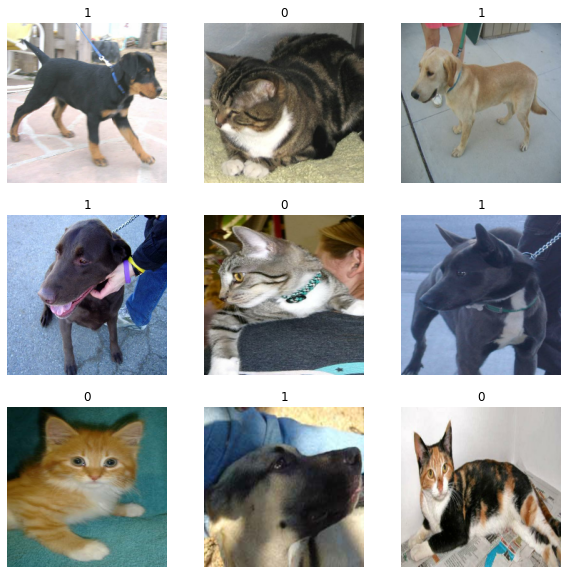

In [176]:
import matplotlib.pyplot as plt

# figure 크기를 조절합니다.
plt.figure(figsize=(10, 10))

# 배치 하나를 가져옵니다.
for images, labels in train_ds.take(1):
    print(labels.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [177]:
from tensorflow.keras.utils import plot_model

def residual_Box(inputs, is_resnet,is_34):
    if is_34:
        for block_num,(repeat_count,filters) in enumerate(zip([3,4,6,3],[64,128,256,512])):
            for i in range(repeat_count):
                if block_num!=0 and i==0:
                    x = keras.layers.Conv2D(filters, 3, strides=2, padding='same',
                                                name="block_stage{0}_step{1}".format(block_num,i))(inputs)
                else:
                    x = keras.layers.Conv2D(filters, 3, padding='same',
                                                name="block_stage{0}_step{1}".format(block_num,i))(inputs)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.ReLU()(x)
                x = keras.layers.Conv2D(filters, 3, padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                if is_resnet:
                    if inputs.shape[1] != x.shape[1]: # 이미지 크기 다른경우
                        inputs = tf.keras.layers.Conv2D(filters, 1, strides=2, padding='same')(inputs)
                        inputs = tf.keras.layers.BatchNormalization()(inputs)
                        
                    x = tf.keras.layers.Add()([x, inputs])
                    
                inputs = keras.layers.ReLU()(x)
            
    else: #50
        for block_num,(repeat_count,filters) in enumerate(zip([3,4,6,3],[64,128,256,512])):
            for i in range(repeat_count):
                if block_num!=0 and i==0:
                    x = keras.layers.Conv2D(filters, 1, strides=2, padding='same',
                                                name="block_stage{0}_step{1}".format(block_num,i))(inputs)
                else:
                    x = keras.layers.Conv2D(filters, 1, padding='same',
                                                name="block_stage{0}_step{1}".format(block_num,i))(inputs)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.ReLU()(x)
                    
                x = keras.layers.Conv2D(filters, 3, padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.ReLU()(x)
                    
                x = keras.layers.Conv2D(filters*4, 1, padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                    
                if is_resnet:
                    if inputs.shape[1] != x.shape[1]: # 이미지 크기 다른경우 
                        inputs = tf.keras.layers.Conv2D(filters*4, 1, strides=2, padding='same')(inputs)
                        inputs = tf.keras.layers.BatchNormalization()(inputs)
                        
                    if inputs.shape[-1] != x.shape[-1]: # 차원수가 다를때 첫번째 (residual layer 경우에만)
                        inputs = tf.keras.layers.Conv2D(filters*4, 1, strides=1, padding='same')(inputs)
                        inputs = tf.keras.layers.BatchNormalization()(inputs)   
                    x = tf.keras.layers.Add()([x, inputs])
                        
                inputs = keras.layers.ReLU()(x)
 
    return inputs
        
    
                

def build_model(input_shape, num_classes, is_resnet, is_34):
    inputs = keras.layers.Input(shape=input_shape)
    #x = keras.layers.experimental.preprocessing.Rescaling(1.0/255)(inputs)
    x = keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs) #112,112,64
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=3,strides=2,padding='same',name='first_maxpooling')(x) ##56,56,64
    x = residual_Box(x,is_resnet,is_34)
    output = keras.layers.AveragePooling2D(padding = 'same')(x)
    output = keras.layers.Flatten(name='flatten')(output)
    if num_classes==2:
        output = keras.layers.Dense(1, activation='sigmoid')(output)
        #output = keras.layers.Dense(num_classes, activation='softmax')(output)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax')(output)
    
    model = tf.keras.Model(inputs, output)
    return model

resnet_34_model = build_model((224,224,3),2,True,True)
Plain_34_model = build_model((224,224,3),2,False,True)
resnet_50_model = build_model((224,224,3),2,True,False)
Plain_50_model = build_model((224,224,3),2,False,False)

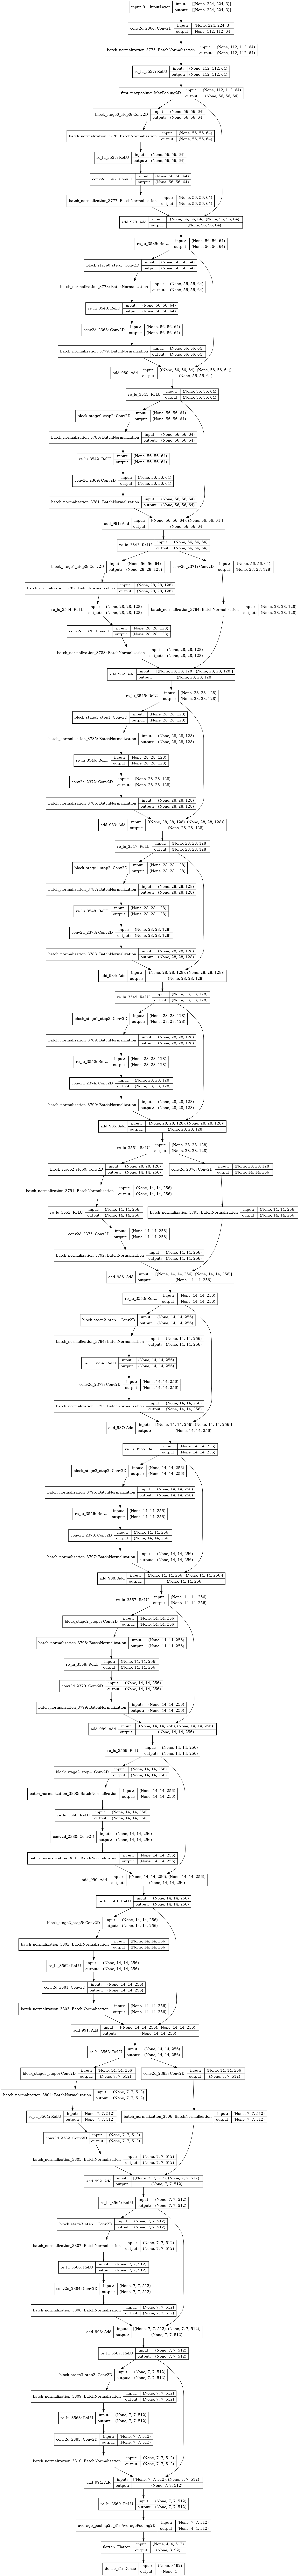

In [230]:
plot_model(resnet_34_model, to_file='resnet34_model.png', show_shapes=True)

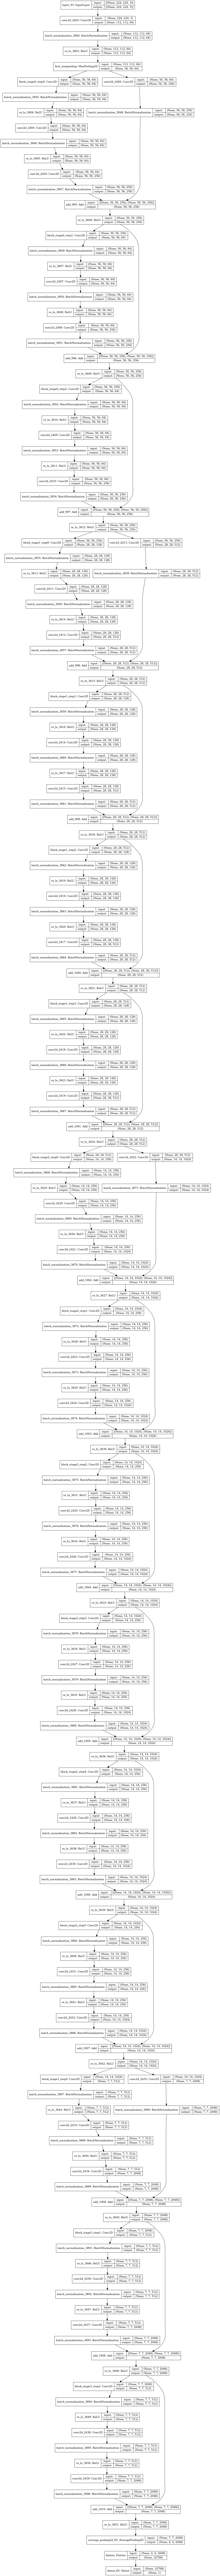

In [231]:
plot_model(resnet_50_model, to_file='resnet50_model.png', show_shapes=True)

In [232]:
resnet_34_model.summary()

Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2366 (Conv2D)            (None, 112, 112, 64) 9472        input_91[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3775 (Batch (None, 112, 112, 64) 256         conv2d_2366[0][0]                
__________________________________________________________________________________________________
re_lu_3537 (ReLU)               (None, 112, 112, 64) 0           batch_normalization_3775[0][0]   
___________________________________________________________________________________________

In [233]:
resnet_50_model.summary()

Model: "model_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_93 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2403 (Conv2D)            (None, 112, 112, 64) 9472        input_93[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3844 (Batch (None, 112, 112, 64) 256         conv2d_2403[0][0]                
__________________________________________________________________________________________________
re_lu_3603 (ReLU)               (None, 112, 112, 64) 0           batch_normalization_3844[0][0]   
___________________________________________________________________________________________

In [234]:
Plain_34_model.summary()

Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2386 (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_3811 (Ba (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_3570 (ReLU)            (None, 112, 112, 64)      0         
_________________________________________________________________
first_maxpooling (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
block_stage0_step0 (Conv2D)  (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_3812 (Ba (None, 56, 56, 64)        256

In [235]:
Plain_50_model.summary()

Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_94 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2440 (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_3897 (Ba (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_3652 (ReLU)            (None, 112, 112, 64)      0         
_________________________________________________________________
first_maxpooling (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
block_stage0_step0 (Conv2D)  (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_3898 (Ba (None, 56, 56, 64)        256

In [223]:
# 데이터 처리 에러가 나서 임시방편으로 새로 만듬 원인불명..
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 데이터 전처리 및 증강
image_size = (224, 224)  # 이미지 크기 설정
batch_size = 32

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rescale=1./255,validation_split=0.8  # 이미지 스케일 조정
)

# 훈련 데이터셋 생성
train_dataset = datagen.flow_from_directory(
    Path,
    subset="training",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

datagen = ImageDataGenerator(
    rescale=1./255,validation_split=0.002  # 이미지 스케일 조정
)

# 훈련 데이터셋 생성
validation_dataset = datagen.flow_from_directory(
    Path,
    subset='validation',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

print(train_dataset)

Found 5000 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [224]:
epochs = 15

resnet_34_model.compile(optimizer=keras.optimizers.Adam(),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_resnet34=resnet_34_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/15
157/157 [==============================] - 31s 179ms/step - loss: 0.5604 - accuracy: 0.7210 - val_loss: 0.9091 - val_accuracy: 0.5200
Epoch 2/15
157/157 [==============================] - 27s 174ms/step - loss: 0.5190 - accuracy: 0.7442 - val_loss: 0.9076 - val_accuracy: 0.7000
Epoch 3/15
157/157 [==============================] - 28s 176ms/step - loss: 0.5262 - accuracy: 0.7418 - val_loss: 0.7482 - val_accuracy: 0.6600
Epoch 4/15
157/157 [==============================] - 28s 176ms/step - loss: 0.5040 - accuracy: 0.7510 - val_loss: 0.4714 - val_accuracy: 0.7600
Epoch 5/15
157/157 [==============================] - 28s 177ms/step - loss: 0.4686 - accuracy: 0.7758 - val_loss: 0.8491 - val_accuracy: 0.6000
Epoch 6/15
157/157 [==============================] - 28s 178ms/step - loss: 0.4419 - accuracy: 0.7902 - val_loss: 0.8035 - val_accuracy: 0.6400
Epoch 7/15
157/157 [==============================] - 28s 178ms/step - loss: 0.4260 - accuracy: 0.8016 - val_loss: 0.4665 - val_ac

In [225]:
Plain_34_model.compile(optimizer=keras.optimizers.Adam(),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_Plain34=Plain_34_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/15
157/157 [==============================] - 31s 177ms/step - loss: 0.7842 - accuracy: 0.5096 - val_loss: 161.0637 - val_accuracy: 0.5000
Epoch 2/15
157/157 [==============================] - 27s 173ms/step - loss: 0.7594 - accuracy: 0.5082 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 3/15
157/157 [==============================] - 27s 174ms/step - loss: 0.7117 - accuracy: 0.5038 - val_loss: 0.7122 - val_accuracy: 0.5000
Epoch 4/15
157/157 [==============================] - 27s 173ms/step - loss: 0.7261 - accuracy: 0.5092 - val_loss: 0.9054 - val_accuracy: 0.5200
Epoch 5/15
157/157 [==============================] - 27s 174ms/step - loss: 0.7208 - accuracy: 0.5056 - val_loss: 11.8431 - val_accuracy: 0.5000
Epoch 6/15
157/157 [==============================] - 27s 173ms/step - loss: 0.7160 - accuracy: 0.4908 - val_loss: 0.7698 - val_accuracy: 0.5120
Epoch 7/15
157/157 [==============================] - 27s 174ms/step - loss: 0.7067 - accuracy: 0.5022 - val_loss: 0.6817 - val

In [226]:
resnet_50_model.compile(optimizer=keras.optimizers.Adam(),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_resnet50=resnet_50_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/15
157/157 [==============================] - 58s 339ms/step - loss: 1.7353 - accuracy: 0.5166 - val_loss: 0.7460 - val_accuracy: 0.5000
Epoch 2/15
157/157 [==============================] - 51s 325ms/step - loss: 1.1728 - accuracy: 0.5578 - val_loss: 1.0771 - val_accuracy: 0.5000
Epoch 3/15
157/157 [==============================] - 51s 326ms/step - loss: 0.7606 - accuracy: 0.6332 - val_loss: 0.6130 - val_accuracy: 0.6200
Epoch 4/15
157/157 [==============================] - 51s 326ms/step - loss: 0.6722 - accuracy: 0.6466 - val_loss: 1.0326 - val_accuracy: 0.7200
Epoch 5/15
157/157 [==============================] - 51s 326ms/step - loss: 0.6202 - accuracy: 0.6758 - val_loss: 0.6433 - val_accuracy: 0.6400
Epoch 6/15
157/157 [==============================] - 51s 326ms/step - loss: 0.5991 - accuracy: 0.6926 - val_loss: 0.8203 - val_accuracy: 0.6600
Epoch 7/15
157/157 [==============================] - 51s 326ms/step - loss: 0.5611 - accuracy: 0.7136 - val_loss: 0.6924 - val_ac

In [227]:
Plain_50_model.compile(optimizer=keras.optimizers.Adam(),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_Plain50=Plain_50_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/15
157/157 [==============================] - 47s 272ms/step - loss: 0.9419 - accuracy: 0.4996 - val_loss: 224.1372 - val_accuracy: 0.5600
Epoch 2/15
157/157 [==============================] - 42s 265ms/step - loss: 0.7911 - accuracy: 0.4996 - val_loss: 6.5955 - val_accuracy: 0.4600
Epoch 3/15
157/157 [==============================] - 42s 265ms/step - loss: 0.7410 - accuracy: 0.5050 - val_loss: 0.7000 - val_accuracy: 0.4600
Epoch 4/15
157/157 [==============================] - 42s 266ms/step - loss: 0.7292 - accuracy: 0.5182 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/15
157/157 [==============================] - 42s 264ms/step - loss: 0.7676 - accuracy: 0.5028 - val_loss: 1.3513 - val_accuracy: 0.5000
Epoch 6/15
157/157 [==============================] - 42s 265ms/step - loss: 0.7340 - accuracy: 0.4978 - val_loss: 1.0015 - val_accuracy: 0.4400
Epoch 7/15
157/157 [==============================] - 42s 264ms/step - loss: 0.7173 - accuracy: 0.5064 - val_loss: 1.2146 - val_

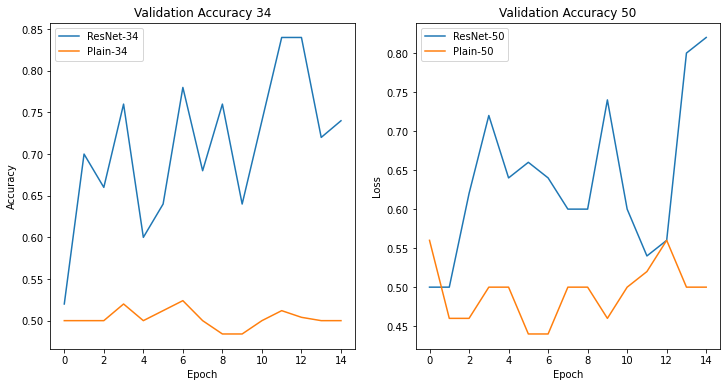

In [229]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet34.history['val_accuracy'], label='ResNet-34')
ax1.plot(history_Plain34.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy 34')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_resnet50.history['val_accuracy'], label='ResNet-50')
ax2.plot(history_Plain50.history['val_accuracy'], label='Plain-50')
ax2.set_title('Validation Accuracy 50')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()